<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/Full_Linear_Evaluation_Imagenet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Thu Aug 20 13:42:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Restoring model weights from GCS Bucket

In [3]:
!wget https://storage.googleapis.com/resnet-simclr-pseudo-labels/resnet_simclr_modified_ae.h5

--2020-08-20 13:42:39--  https://storage.googleapis.com/resnet-simclr-pseudo-labels/resnet_simclr_modified_ae.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.188.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96848264 (92M) [application/octet-stream]
Saving to: ‘resnet_simclr_modified_ae.h5’

resnet_simclr_modif 100%[===================>]  92.36M   183MB/s    in 0.5s    

2020-08-20 13:42:40 (183 MB/s) - ‘resnet_simclr_modified_ae.h5’ saved [96848264/96848264]



In [4]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset gathering and preparation

In [5]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 7.75 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [6]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [7]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [8]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  4%|▎         | 9/250 [00:00<00:02, 89.83it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 180.92it/s]


(250, 224, 224, 3) (250,)


In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [29]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [30]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('resnet_simclr_modified_ae.h5')
resnet_simclr.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               524544    
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_11 (Activation)   (None, 128)             

In [31]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [32]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [33]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               524544    
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_11 (Activation)   (None, 128)             

In [34]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 128) (250, 128)


In [35]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/100
20/20 [==============================] - 0s 11ms/step - loss: 2.6788 - accuracy: 0.2304 - val_loss: 1.9835 - val_accuracy: 0.3240
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1.8576 - accuracy: 0.3296 - val_loss: 1.4875 - val_accuracy: 0.4360
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 1.5055 - accuracy: 0.4264 - val_loss: 1.2914 - val_accuracy: 0.4840
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3410 - accuracy: 0.4768 - val_loss: 1.2092 - val_accuracy: 0.5320
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2486 - accuracy: 0.5152 - val_loss: 1.1565 - val_accuracy: 0.5560
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1933 - accuracy: 0.5336 - val_loss: 1.1178 - val_accuracy: 0.5760
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1453 - accuracy: 0.5432 - val_loss: 1.0924 - val_accuracy: 0.5880
Epoch 8/100


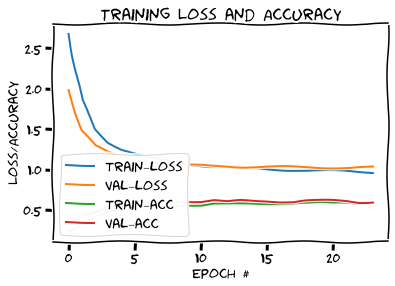

In [36]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [37]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 256) (250, 256)


Epoch 1/35
20/20 [==============================] - 0s 9ms/step - loss: 2.9166 - accuracy: 0.2920 - val_loss: 1.9997 - val_accuracy: 0.3240
Epoch 2/35
20/20 [==============================] - 0s 3ms/step - loss: 1.6844 - accuracy: 0.4344 - val_loss: 1.3324 - val_accuracy: 0.4840
Epoch 3/35
20/20 [==============================] - 0s 3ms/step - loss: 1.2953 - accuracy: 0.5056 - val_loss: 1.1830 - val_accuracy: 0.5280
Epoch 4/35
20/20 [==============================] - 0s 3ms/step - loss: 1.1884 - accuracy: 0.5208 - val_loss: 1.1316 - val_accuracy: 0.5280
Epoch 5/35
20/20 [==============================] - 0s 4ms/step - loss: 1.1315 - accuracy: 0.5408 - val_loss: 1.1134 - val_accuracy: 0.5200
Epoch 6/35
20/20 [==============================] - 0s 3ms/step - loss: 1.1068 - accuracy: 0.5552 - val_loss: 1.1166 - val_accuracy: 0.5240
Epoch 7/35
20/20 [==============================] - 0s 4ms/step - loss: 1.0858 - accuracy: 0.5488 - val_loss: 1.0841 - val_accuracy: 0.5440
Epoch 8/35
20/20 [==

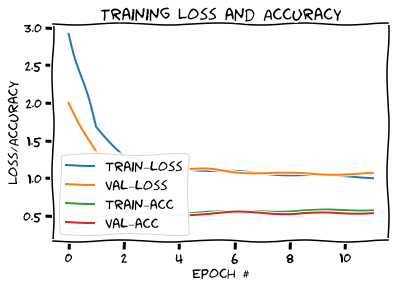

In [38]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [39]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 2048) (250, 2048)


Epoch 1/35
20/20 [==============================] - 0s 10ms/step - loss: 1.6049 - accuracy: 0.4040 - val_loss: 1.0845 - val_accuracy: 0.5640
Epoch 2/35
20/20 [==============================] - 0s 5ms/step - loss: 1.1533 - accuracy: 0.5288 - val_loss: 1.0198 - val_accuracy: 0.5920
Epoch 3/35
20/20 [==============================] - 0s 4ms/step - loss: 1.0518 - accuracy: 0.5464 - val_loss: 1.0269 - val_accuracy: 0.5800
Epoch 4/35
20/20 [==============================] - 0s 4ms/step - loss: 1.0316 - accuracy: 0.5600 - val_loss: 1.0435 - val_accuracy: 0.5560
Epoch 00004: early stopping


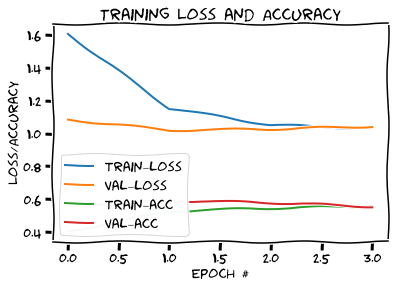

In [40]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)